In [39]:
import pandas as pd
import numpy as np

# === 1) Importar CSV ===
CAMINHO_ARQUIVO = "Assets.csv"

df = pd.read_csv(
    CAMINHO_ARQUIVO,
    sep=";",                # separador do seu arquivo
    header=0,
    parse_dates=[0],        # primeira coluna é data
    date_format="%d-%b-%y"  # formato das datas: 31-out-01
)

# Renomeia primeira coluna para "Data" (se necessário) e define como índice
if df.columns[0] != "Data":
    df.rename(columns={df.columns[0]: "Data"}, inplace=True)
df.set_index("Data", inplace=True)

# === 2) Selecionar 6 ativos ===
precos = df[["PU_252_DU", "PU_504_DU", "PETR4", "VALE5", "TNLP4", "Dolar Spot"]].copy()

# Converte índice para datetime (garantia extra)
precos.index = pd.to_datetime(precos.index, format="%d-%b-%y", errors="coerce")

# === 3) Calcular retornos ===
ret = precos.pct_change(fill_method=None).dropna(how="all")   # sem warnings

# === 4) Métricas individuais ===
ANUALIZADOR = 252  # dias úteis no ano

mean_p = ret.mean()
vol_p  = ret.std(ddof=1)

# Anualização
mean_a = (1 + mean_p)**ANUALIZADOR - 1
vol_a  = vol_p * np.sqrt(ANUALIZADOR)

# Retorno/risco (Sharpe sem RF)
rr_a = mean_a / vol_a

# === 5) Carteira equal-weight ===
n = ret.shape[1]
w = np.repeat(1/n, n)        # pesos iguais (6 ativos → ~16,67% cada)
ret_port = ret @ w           # retorno da carteira por período

mean_p_port = ret_port.mean()
vol_p_port  = ret_port.std(ddof=1)
mean_a_port = (1 + mean_p_port)**ANUALIZADOR - 1
vol_a_port  = vol_p_port * np.sqrt(ANUALIZADOR)
rr_port_a   = mean_a_port / vol_a_port

# === 6) Tabela resumo ===
resumo = pd.DataFrame({
    "Retorno_médio_período": mean_p,
    "Vol_período": vol_p,
    "Retorno_médio_anual": mean_a,
    "Vol_anual": vol_a,
    "Retorno_por_risco_anual": rr_a
})

resumo_port = pd.Series({
    "Retorno_médio_período": mean_p_port,
    "Vol_período": vol_p_port,
    "Retorno_médio_anual": mean_a_port,
    "Vol_anual": vol_a_port,
    "Retorno_por_risco_anual": rr_port_a
}, name="CART_EQW")

resumo = pd.concat([resumo, resumo_port.to_frame().T])

# === 7) Extras: Covariância e Correlação ===
cov_a = ret.cov() * ANUALIZADOR
corr  = ret.corr()

print("Período:", precos.index.min().date(), "→", precos.index.max().date())
print("\nPesos da carteira equal-weight:", w)

display(resumo)
print("\nMatriz de covariância anualizada:")
display(cov_a)
print("\nMatriz de correlação:")
display(corr)

Período: 2001-11-30 → 2006-01-31

Pesos da carteira equal-weight: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


,Retorno_médio_período,Vol_período,Retorno_médio_anual,Vol_anual,Retorno_por_risco_anual
PU_252_DU,0.001637,0.015202,0.510293,0.241326,2.114540
PU_504_DU,0.005183,0.039777,2.679190,0.631437,4.243007
PETR4,0.033477,0.094081,4014.770212,1.493491,2688.177715
VALE5,0.040039,0.096687,19791.152201,1.534859,12894.446576
TNLP4,0.017524,0.101574,78.664207,1.612441,48.785779
Dolar Spot,-0.002417,0.066413,-0.456605,1.054267,-0.433101
CART_EQW,0.015907,0.034666,52.358666,0.550312,95.143575



Matriz de covariância anualizada:


,PU_252_DU,PU_504_DU,PETR4,VALE5,TNLP4,Dolar Spot
PU_252_DU,0.058238,0.146375,0.185006,-0.085998,0.227208,-0.204125
PU_504_DU,0.146375,0.398712,0.504725,-0.244414,0.650738,-0.527406
PETR4,0.185006,0.504725,2.230516,0.755371,1.064044,-0.818940
VALE5,-0.085998,-0.244414,0.755371,2.355791,-0.000603,0.379983
TNLP4,0.227208,0.650738,1.064044,-0.000603,2.599967,-0.958134
Dolar Spot,-0.204125,-0.527406,-0.818940,0.379983,-0.958134,1.111480



Matriz de correlação:


,PU_252_DU,PU_504_DU,PETR4,VALE5,TNLP4,Dolar Spot
PU_252_DU,1.000000,0.960578,0.513311,-0.232175,0.583898,-0.802311
PU_504_DU,0.960578,1.000000,0.535207,-0.252191,0.639135,-0.792254
PETR4,0.513311,0.535207,1.000000,0.329526,0.441848,-0.520114
VALE5,-0.232175,-0.252191,0.329526,1.000000,-0.000244,0.234826
TNLP4,0.583898,0.639135,0.441848,-0.000244,1.000000,-0.563627
Dolar Spot,-0.802311,-0.792254,-0.520114,0.234826,-0.563627,1.000000


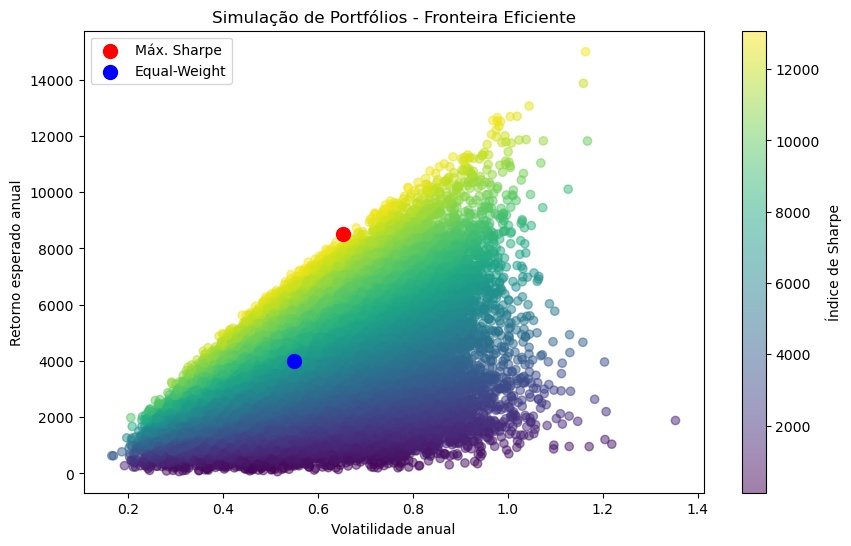

Pesos carteira de Máx. Sharpe:
PU_252_DU     0.200470
PU_504_DU     0.336976
PETR4         0.010646
VALE5         0.428556
TNLP4         0.001977
Dolar Spot    0.021375
dtype: float64

Retorno anual esperado: 8525.514954326134
Volatilidade anual: 0.6519304669673949
Sharpe Ratio: 13077.337824054359

Pesos carteira Equal-Weight: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Retorno anual esperado (EQW): 3981.2199161383405
Volatilidade anual (EQW): 0.5503121532227828
Sharpe Ratio (EQW): 7234.475729498607


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1) Importar os dados ===
CAMINHO_ARQUIVO = "Assets.csv"

df = pd.read_csv(
    CAMINHO_ARQUIVO,
    sep=";",
    header=0,
    parse_dates=[0],
    date_format="%d-%b-%y"
)

if df.columns[0] != "Data":
    df.rename(columns={df.columns[0]: "Data"}, inplace=True)
df.set_index("Data", inplace=True)

# Selecionar os 6 ativos
precos = df[["PU_252_DU", "PU_504_DU", "PETR4", "VALE5", "TNLP4", "Dolar Spot"]].copy()
precos.index = pd.to_datetime(precos.index, format="%d-%b-%y", errors="coerce")

# === 2) Retornos ===
ret = precos.pct_change(fill_method=None).dropna(how="all")

ANUALIZADOR = 252
mean_a = (1 + ret.mean())**ANUALIZADOR - 1
cov_a = ret.cov() * ANUALIZADOR

# === 3) Simulação de portfólios ===
n_assets = len(mean_a)
n_sim = 50000  # número de carteiras simuladas

results = np.zeros((3, n_sim))
weights_record = []

for i in range(n_sim):
    # gera pesos aleatórios que somam 1
    w = np.random.random(n_assets)
    w /= np.sum(w)
    weights_record.append(w)
    
    # retorno e risco
    port_return = np.dot(w, mean_a)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_a, w)))
    sharpe = port_return / port_vol
    
    results[0, i] = port_vol
    results[1, i] = port_return
    results[2, i] = sharpe

# === 4) Identificar carteiras especiais ===
max_sharpe_idx = results[2].argmax()
vol_max_sharpe, ret_max_sharpe, sharpe_max = results[:, max_sharpe_idx]
weights_max_sharpe = weights_record[max_sharpe_idx]

# Carteira equal-weight
w_eqw = np.repeat(1/n_assets, n_assets)
ret_eqw = np.dot(w_eqw, mean_a)
vol_eqw = np.sqrt(np.dot(w_eqw.T, np.dot(cov_a, w_eqw)))
sharpe_eqw = ret_eqw / vol_eqw

# === 5) Gráfico da fronteira eficiente ===
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap="viridis", alpha=0.5)
plt.colorbar(label="Índice de Sharpe")
plt.xlabel("Volatilidade anual")
plt.ylabel("Retorno esperado anual")
plt.title("Simulação de Portfólios - Fronteira Eficiente")

# Marcar carteira de máxima Sharpe
plt.scatter(vol_max_sharpe, ret_max_sharpe, c="red", s=100, label="Máx. Sharpe")

# Marcar carteira equal-weight
plt.scatter(vol_eqw, ret_eqw, c="blue", s=100, label="Equal-Weight")

plt.legend()
plt.show()

# === 6) Exibir pesos da carteira ótima ===
ativos = mean_a.index.tolist()
pesos_otimos = pd.Series(weights_max_sharpe, index=ativos)

print("Pesos carteira de Máx. Sharpe:")
print(pesos_otimos)
print("\nRetorno anual esperado:", ret_max_sharpe)
print("Volatilidade anual:", vol_max_sharpe)
print("Sharpe Ratio:", sharpe_max)

print("\nPesos carteira Equal-Weight:", w_eqw)
print("Retorno anual esperado (EQW):", ret_eqw)
print("Volatilidade anual (EQW):", vol_eqw)
print("Sharpe Ratio (EQW):", sharpe_eqw)



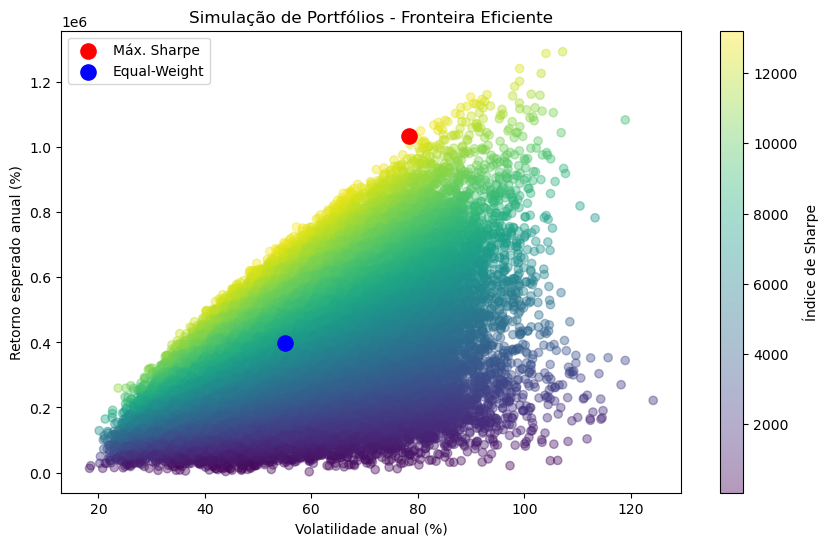

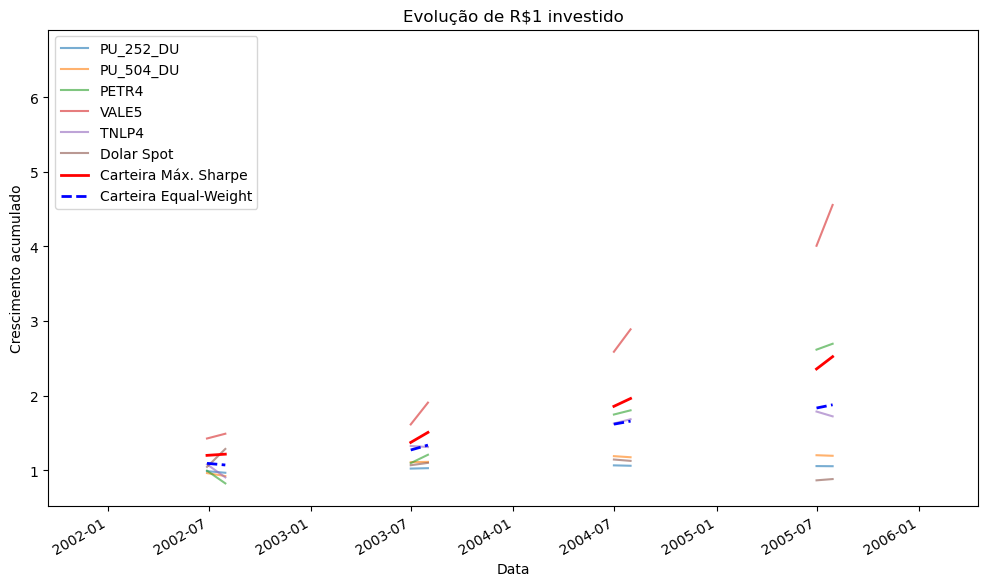

Pesos carteira de Máx. Sharpe:
PU_252_DU     0.188439
PU_504_DU     0.247114
PETR4         0.007954
VALE5         0.521656
TNLP4         0.005865
Dolar Spot    0.028972
dtype: float64

Carteira Máx. Sharpe:
Retorno anual esperado: 1035730.88%
Volatilidade anual: 78.40%
Sharpe Ratio: 13210.89

Carteira Equal-Weight:
Retorno anual esperado: 398121.99%
Volatilidade anual: 55.03%
Sharpe Ratio: 7234.48


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1) Importar os dados ===
CAMINHO_ARQUIVO = "Assets.csv"

df = pd.read_csv(
    CAMINHO_ARQUIVO,
    sep=";",
    header=0,
    parse_dates=[0],
    date_format="%d-%b-%y"
)

if df.columns[0] != "Data":
    df.rename(columns={df.columns[0]: "Data"}, inplace=True)
df.set_index("Data", inplace=True)

# Selecionar os 6 ativos
precos = df[["PU_252_DU", "PU_504_DU", "PETR4", "VALE5", "TNLP4", "Dolar Spot"]].copy()
precos.index = pd.to_datetime(precos.index, format="%d-%b-%y", errors="coerce")

# === 2) Retornos ===
ret = precos.pct_change(fill_method=None).dropna(how="all")

ANUALIZADOR = 252
mean_a = (1 + ret.mean())**ANUALIZADOR - 1
cov_a = ret.cov() * ANUALIZADOR

# === 3) Simulação de portfólios ===
n_assets = len(mean_a)
n_sim = 50000  # número de carteiras simuladas

results = np.zeros((3, n_sim))
weights_record = []

for i in range(n_sim):
    w = np.random.random(n_assets)
    w /= np.sum(w)
    weights_record.append(w)
    
    port_return = np.dot(w, mean_a)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_a, w)))
    sharpe = port_return / port_vol
    
    results[0, i] = port_vol
    results[1, i] = port_return
    results[2, i] = sharpe

# === 4) Identificar carteiras especiais ===
max_sharpe_idx = results[2].argmax()
vol_max_sharpe, ret_max_sharpe, sharpe_max = results[:, max_sharpe_idx]
weights_max_sharpe = weights_record[max_sharpe_idx]

# Carteira equal-weight
w_eqw = np.repeat(1/n_assets, n_assets)
ret_eqw = np.dot(w_eqw, mean_a)
vol_eqw = np.sqrt(np.dot(w_eqw.T, np.dot(cov_a, w_eqw)))
sharpe_eqw = ret_eqw / vol_eqw

# === 5) Gráfico 1: Fronteira eficiente ===
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :]*100, results[1, :]*100, c=results[2, :], cmap="viridis", alpha=0.4)
plt.colorbar(label="Índice de Sharpe")
plt.xlabel("Volatilidade anual (%)")
plt.ylabel("Retorno esperado anual (%)")
plt.title("Simulação de Portfólios - Fronteira Eficiente")

plt.scatter(vol_max_sharpe*100, ret_max_sharpe*100, c="red", s=120, label="Máx. Sharpe")
plt.scatter(vol_eqw*100, ret_eqw*100, c="blue", s=120, label="Equal-Weight")
plt.legend()
plt.show()

# === 6) Gráfico 2: Evolução de R$1 investido ===
ret_port_max_sharpe = ret @ weights_max_sharpe
cumul_port_max = (1 + ret_port_max_sharpe).cumprod()

ret_port_eqw = ret @ w_eqw
cumul_port_eqw = (1 + ret_port_eqw).cumprod()

plt.figure(figsize=(12, 7))
for col in precos.columns:
    (precos[col] / precos[col].iloc[0]).plot(label=col, alpha=0.6)

cumul_port_max.plot(label="Carteira Máx. Sharpe", color="red", linewidth=2)
cumul_port_eqw.plot(label="Carteira Equal-Weight", color="blue", linewidth=2, linestyle="--")

plt.title("Evolução de R$1 investido")
plt.ylabel("Crescimento acumulado")
plt.legend()
plt.show()

# === 7) Pesos e métricas ===
ativos = mean_a.index.tolist()
pesos_otimos = pd.Series(weights_max_sharpe, index=ativos)

print("Pesos carteira de Máx. Sharpe:")
print(pesos_otimos)

print("\nCarteira Máx. Sharpe:")
print(f"Retorno anual esperado: {ret_max_sharpe*100:.2f}%")
print(f"Volatilidade anual: {vol_max_sharpe*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_max:.2f}")

print("\nCarteira Equal-Weight:")
print(f"Retorno anual esperado: {ret_eqw*100:.2f}%")
print(f"Volatilidade anual: {vol_eqw*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_eqw:.2f}")
